## CNN for Cats vs. Dogs Classification


# **1. Cleaning the Dataset**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from PIL import Image

# For reproducibility
tf.random.set_seed(42)


def remove_corrupted_images(directory):
    removed_files = 0
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that it's an actual image
            except Exception as e:
                print(f"Removing corrupted file: {file_path} - {e}")
                os.remove(file_path)
                removed_files += 1
    print(f"Removed {removed_files} corrupted files.")

# Update this to your dataset directory
file_path = "/Users/Shared/D/Uni/Semester8/GenAI/images"
remove_corrupted_images(file_path)


Removed 0 corrupted files.


# **2. Data Preparation and Augmentation**


In [ ]:
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data for validation
)

# Training data generator
train_generator = datagen.flow_from_directory(
    file_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    file_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 9601 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


# **3. CNN Model Implementation**

In [14]:
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Fourth convolutional block (extra layer)
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Flatten and Dense layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: cat vs. dog
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

callbacks = [earlystop, reduce_lr]



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,700,289 (21.74 MB)

 Trainable params: 5,698,817 (21.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

# **4. Training the Model**

In [ ]:

EPOCHS = 40

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 251ms/step - accuracy: 0.5869 - loss: 0.9320 - val_accuracy: 0.5183 - val_loss: 0.7521 - learning_rate: 0.0010
Epoch 2/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6875 - loss: 0.7691 - val_accuracy: 0.5138 - val_loss: 0.7575 - learning_rate: 0.0010
Epoch 3/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 254ms/step - accuracy: 0.6605 - loss: 0.6341 - val_accuracy: 0.6938 - val_loss: 0.5698 - learning_rate: 0.0010
Epoch 4/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5938 - loss: 0.6570 - val_accuracy: 0.7054 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 5/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 254ms/step - accuracy: 0.6981 - loss: 0.5755 - val_accuracy: 0.6671 - val_loss: 0.6190 - learning_rate: 0.0010
Epoch 6/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7188 - loss: 0.5248 - val_accuracy: 0.6667 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 7/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7432 - l

# **5. Model Evaluation**

In [21]:
# Reset the generator before predictions
validation_generator.reset()

# Generate predictions on the validation set
Y_pred = model.predict(validation_generator, steps=len(validation_generator))
y_pred = (Y_pred > 0.5).astype("int32")

# True labels
y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

# AUC-ROC
auc = roc_auc_score(y_true, Y_pred)
print("\nAUC-ROC:", auc)


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step
Confusion Matrix:
[[622 578]
 [615 585]]

Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.52      0.51      1200
         Dog       0.50      0.49      0.50      1200

    accuracy                           0.50      2400
   macro avg       0.50      0.50      0.50      2400
weighted avg       0.50      0.50      0.50      2400


AUC-ROC: 0.5036913194444445


# **6. Visualization of Sample Images**

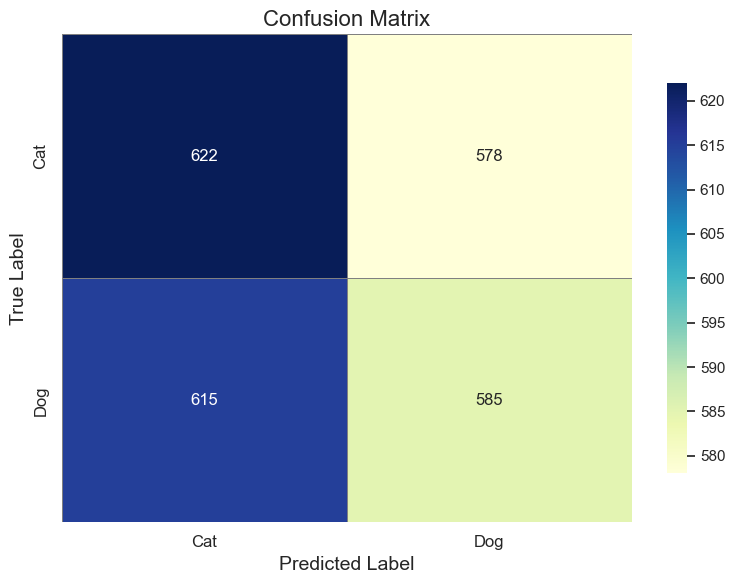

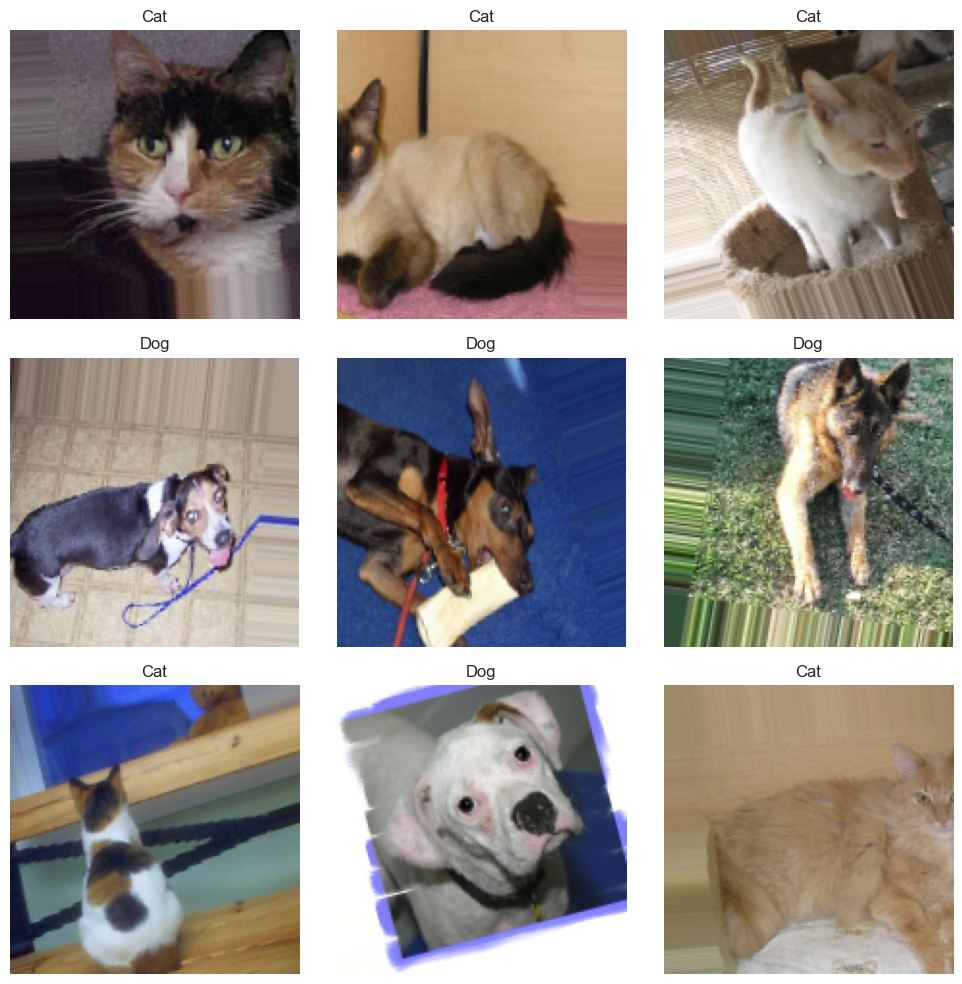

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap='YlGnBu'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
    else:
        fmt = "d"

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'shrink': 0.8}, linewidths=0.5, linecolor='gray')
    
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['Cat', 'Dog'])

images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title("Cat" if labels[i] == 0 else "Dog")
    plt.axis('off')
plt.tight_layout()
plt.show()


# **7. Training and Validation Curves**

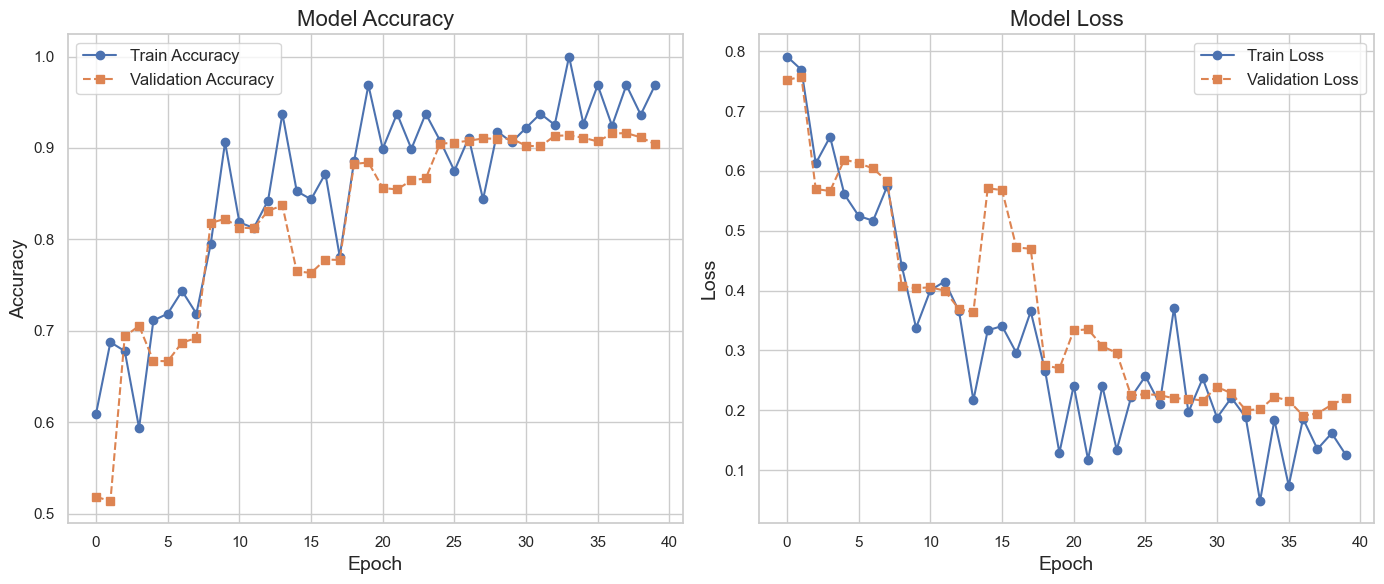

In [23]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Accuracy
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], marker='s', linestyle='--', label='Validation Accuracy')
ax[0].set_title('Model Accuracy', fontsize=16)
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].grid(True)

# Plot Loss
ax[1].plot(history.history['loss'], marker='o', linestyle='-', label='Train Loss')
ax[1].plot(history.history['val_loss'], marker='s', linestyle='--', label='Validation Loss')
ax[1].set_title('Model Loss', fontsize=16)
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)
ax[1].legend(fontsize=12)
ax[1].grid(True)

plt.tight_layout()
plt.show()
